# Model Implementation of Venomous and Non-venomous Snakes

---

1. Install Dependencies and Setup

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from keras.applications import ResNet50, VGG16, DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_dir = r'C:\Users\ivanne bayer\Desktop\Computer Science\Comp Sci - Yr. 3 second sem\CS 3201 - Thesis 1\CS 3201 - Implementation\placeholder'

2. Performing EDA

In [4]:
venomous_dir = os.path.join(data_dir, 'venomous')
non_venomous_dir = os.path.join(data_dir, 'non_venomous')

num_venomous = len([f for f in os.listdir(venomous_dir) if os.path.isfile(os.path.join(venomous_dir, f))])
num_non_venomous = len([f for f in os.listdir(non_venomous_dir) if os.path.isfile(os.path.join(non_venomous_dir, f))])

print("Number of Snakes collected")
print("Venomous: " + str(num_venomous))
print("Non-Venomous: " + str(num_non_venomous))

Number of Snakes collected
Venomous: 1653
Non-Venomous: 3178


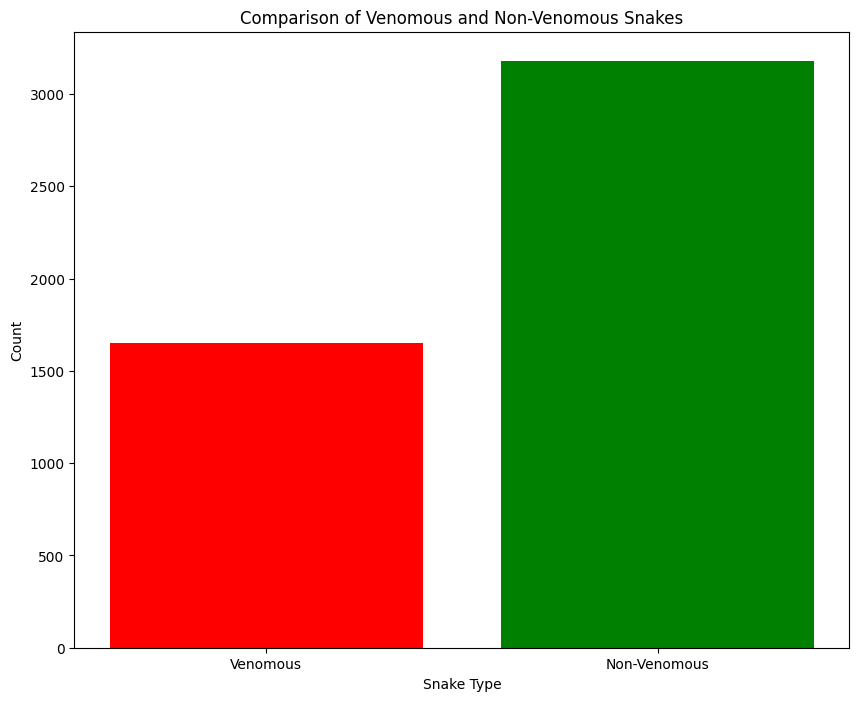

In [5]:
categories = ['Venomous', 'Non-Venomous']
counts = [num_venomous, num_non_venomous]

plt.figure(figsize=(10, 8))
plt.bar(categories, counts, color=['red', 'green'])
plt.xlabel('Snake Type')
plt.ylabel('Count')
plt.title('Comparison of Venomous and Non-Venomous Snakes')
plt.show()

3. Preprocessing the Images with Data Augmentation

In [6]:
def load_images_and_labels(data_dir):
    X = []
    y = []
    for label, folder in enumerate(['venomous', 'non_venomous']):
        folder_path = os.path.join(data_dir, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (224, 224)) 
            image = image.astype('float32') / 255.0 
            
            datagen = ImageDataGenerator(
                horizontal_flip=True,
                zoom_range=0.2
            )
            image = datagen.random_transform(image)
            
            X.append(image)
            y.append(label) 
    return np.array(X), np.array(y)


4. Training and Testing Split

Number of images for training: 3864
Number of images for testing: 967


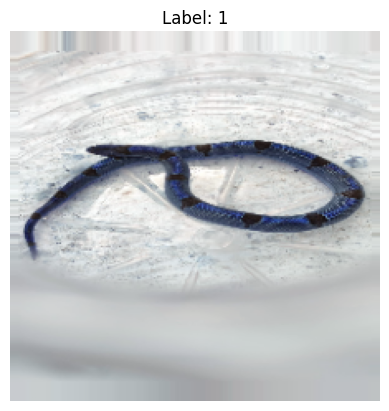

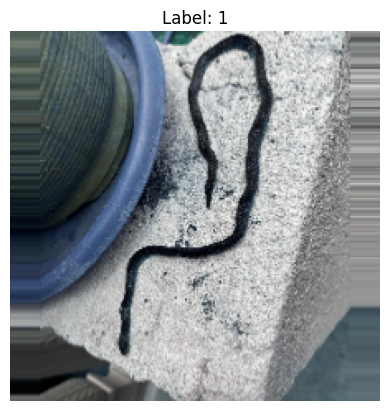

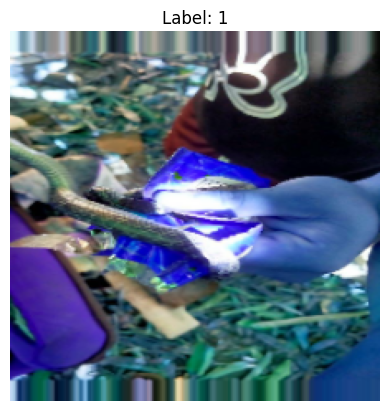

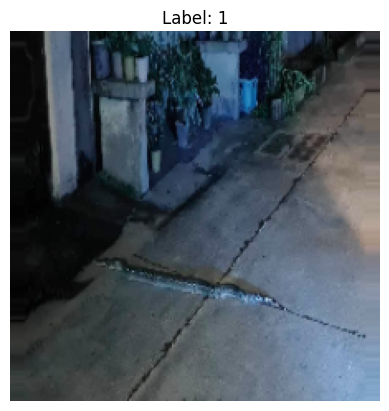

In [8]:
X, y = load_images_and_labels(data_dir)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Number of images for training:", len(X_train))
print("Number of images for testing:", len(X_test))

for i in range(2):
    idx = np.random.randint(len(X_train))
    image = X_train[idx]
    label = y_train[idx]
    plt.imshow(image)
    plt.title('Label: ' + str(label))
    plt.axis('off')
    plt.show()

for i in range(2):
    idx = np.random.randint(len(X_test))
    image = X_test[idx]
    label = y_test[idx]
    plt.imshow(image)
    plt.title('Label: ' + str(label))
    plt.axis('off')
    plt.show()

5. Creating the Models

In [13]:
def create_model(model_name):
    if model_name == 'ResNet50':
        base_model = ResNet50(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 512
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    elif model_name == 'VGG16':
        base_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 256
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    elif model_name == 'DenseNet201':
        base_model = DenseNet201(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 512
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)  
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    base_model.summary()
    
    return model

6. Evaluating the Models

In [10]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    print("Training the model...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    print("Training finished.")
    
    print("Evaluating the model on test data...")
    _, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Evaluation finished.")
    
    return history

7. Train the Models and Identify Mean Performance of each Algorithm

In [14]:
models = {'ResNet50': create_model('ResNet50'), 'VGG16': create_model('VGG16'), 'DenseNet201': create_model('DenseNet201')}

for name, model in models.items():
    print("Training and evaluating", name)
    history = evaluate_model(model, X_train, X_test, y_train, y_test)
    
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy - ' + name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 5,521,408 (21.06 MB)

 Non-trainable params: 18,066,304 (68.92 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 2,434,240 (9.29 MB)

 Non-trainable params: 15,887,744 (60.61 MB)

Training and evaluating ResNet50
Training the model...
Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.6296 - loss: 0.7541 - val_accuracy: 0.6287 - val_loss: 0.6569
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.6761 - loss: 0.6203 - val_accuracy: 0.6277 - val_loss: 0.7081
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.6559 - loss: 0.6412 - val_accuracy: 0.6277 - val_loss: 0.8959
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.6552 - loss: 0.6291 - val_accuracy: 0.6277 - val_loss: 0.6843
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.6711 - loss: 0.6161 - val_accuracy: 0.6277 - val_loss: 0.6742
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.6848 - loss: 0.6149 - val_accuracy: 0.6277 - val_loss: 0.7139
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6536 - loss: 0.6256 - val_accuracy: 0.6215 - val_loss: 0.7183
Epoch 8/10
109/121 ━━━━━━━━━━━━━━━━━━━━ 16

KeyboardInterrupt: 